In [28]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from datetime import datetime

In [29]:
def get_sp500_companies():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    html = requests.get(url).text
    df = pd.read_html(html)[0]
    return df

In [30]:
sp500_companies = get_sp500_companies()
companies = dict(zip(sp500_companies['Security'], sp500_companies['Symbol']))


In [31]:
stock_name = 'Alphabet Inc. (Class A)'  # Example; replace with dynamic selection in your UI
stock = companies[stock_name]

In [32]:
start = '2012-01-01'
end = '2024-07-23'

In [33]:
data = yf.download(stock, start, end)
data = data[::-1]

[*********************100%***********************]  1 of 1 completed


In [34]:
data.reset_index(inplace=True)

In [35]:
ma_100_days = data.Close.rolling(100).mean()

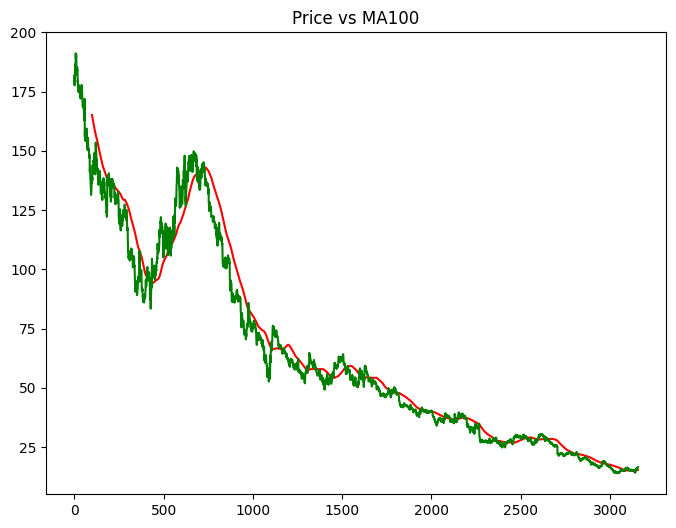

In [36]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.title('Price vs MA100')
plt.show()

In [37]:
ma_200_days = data.Close.rolling(200).mean()

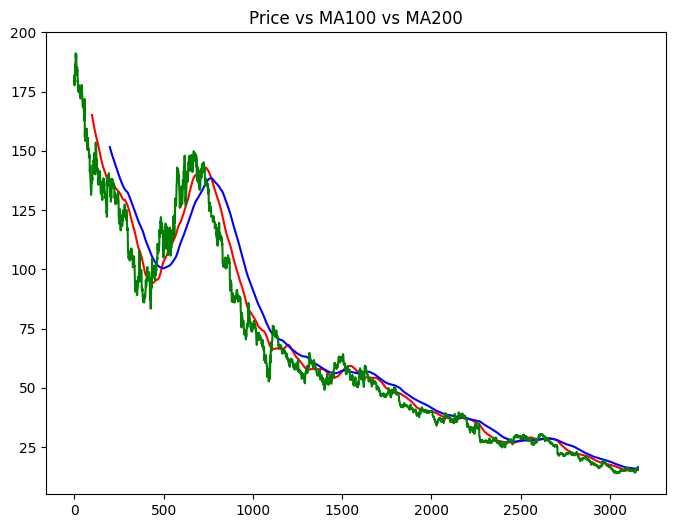

In [38]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days,'b')
plt.plot(data.Close,'g')
plt.title('Price vs MA100 vs MA200')
plt.show()

In [39]:
data.dropna(inplace=True)

/tmp/ipykernel_4626/1368182302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [40]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [41]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

In [42]:
x_train = []
y_train = []

for i in range(100, data_train_scale.shape[0]):
    x_train.append(data_train_scale[i-100:i])
    y_train.append(data_train_scale[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [43]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units =1))

In [44]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [45]:
model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
76/76 [==============================] - 18s 154ms/step - loss: 0.0188
Epoch 2/50
76/76 [==============================] - 11s 148ms/step - loss: 0.0045
Epoch 3/50
76/76 [==============================] - 12s 155ms/step - loss: 0.0041
Epoch 4/50
76/76 [==============================] - 11s 148ms/step - loss: 0.0035
Epoch 5/50
76/76 [==============================] - 11s 147ms/step - loss: 0.0036
Epoch 6/50
76/76 [==============================] - 14s 182ms/step - loss: 0.0035
Epoch 7/50
76/76 [==============================] - 11s 148ms/step - loss: 0.0037
Epoch 8/50
76/76 [==============================] - 11s 149ms/step - loss: 0.0027
Epoch 9/50
76/76 [==============================] - 11s 148ms/step - loss: 0.0027
Epoch 10/50
76/76 [==============================] - 11s 147ms/step - loss: 0.0027
Epoch 11/50
76/76 [==============================] - 11s 147ms/step - loss: 0.0024
Epoch 12/50
76/76 [==============================] - 11s 147ms/step - loss: 0.0026
Epoch 13/50
7

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [47]:
pas_100_days = data_train.tail(100)
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)
data_test_scale = scaler.transform(data_test)

In [48]:
x_test = []
y_test = []

for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i])
    y_test.append(data_test_scale[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [49]:
y_predict = model.predict(x_test)

20/20 [==============================] - 1s 40ms/step


In [50]:
scale = 1/scaler.scale_
y_predict = y_predict * scale
y_test = y_test * scale

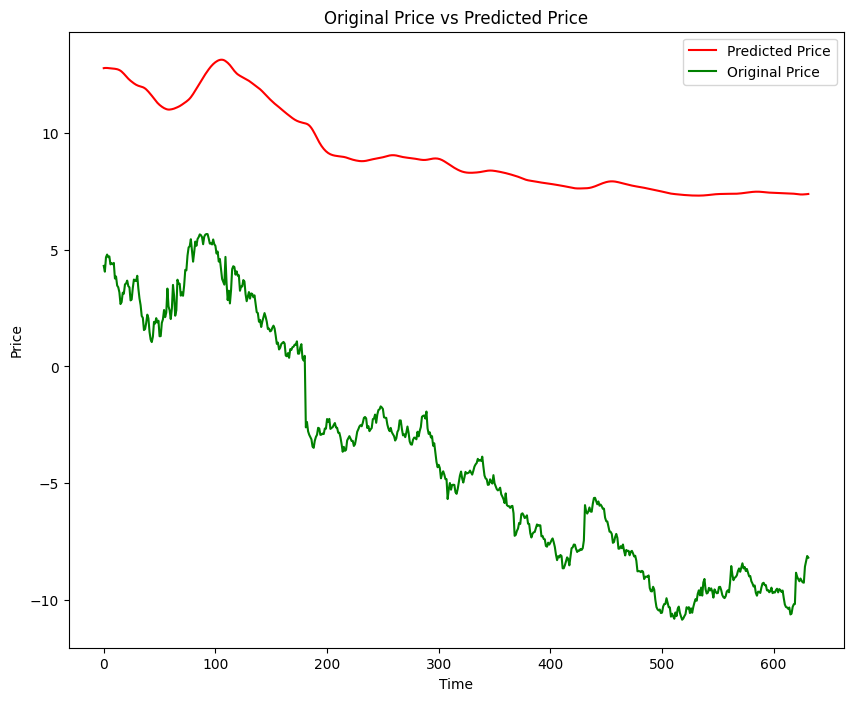

In [51]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label='Predicted Price')
plt.plot(y_test, 'g', label='Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('Original Price vs Predicted Price')
plt.show()

In [52]:
model.save('Stock Predictions Model.keras')